In [1]:
import cv2
import numpy as np
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
import tarfile

### cv2 Color Conversions

By default cv2 reads in images using BGR color codes, the below are helper functions so we can read them in using RGB

In [2]:
def imread_rgb(filepath):
    image_bgr = cv2.imread(filepath)
    return cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

def imwrite_bgr(filepath, image_rgb):
    image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
    cv2.imwrite(filepath, image_bgr)

### Image resizing

Below we resize each image to 256 X 256 for consistency, which becomes convenient when we use the CNNs and MLPs later on. There is no need to run the below cell if we are using the data from getData.sh (see README)

In [3]:
if os.path.exists('data') and os.path.isdir('data'):
    print("data dir already exists")

else:

    images_train = []
    images_test = []


    for filename in os.listdir('data/training_set/cats'):
        if filename.endswith('.jpg'):
            image = imread_rgb(os.path.join('data/training_set/cats', filename))
            image = cv2.resize(image, (256, 256))
            images_train.append(image)

    for filename in os.listdir('data/training_set/dogs'):
        if filename.endswith('.jpg'):
            image = imread_rgb(os.path.join('data/training_set/dogs', filename))
            image = cv2.resize(image, (256, 256))
            images_train.append(image)

    for filename in os.listdir('data/test_set/cats'):
        if filename.endswith('.jpg'):
            image = imread_rgb(os.path.join('data/test_set/cats', filename))
            image = cv2.resize(image, (256, 256))
            images_test.append(image)

    for filename in os.listdir('data/test_set/dogs'):
        if filename.endswith('.jpg'):
            image = imread_rgb(os.path.join('data/test_set/dogs', filename))
            image = cv2.resize(image, (256, 256))
            images_test.append(image)

    random.shuffle(images_train)
    random.shuffle(images_test)

    for i in range(len(images_train)):
        imwrite_bgr(f'data/training_set_resized/training_image_resized_{i+1}.jpg', images_train[i])

    for i in range(len(images_test)):
        imwrite_bgr(f'data/test_set_resized/test_image_resized_{i+1}.jpg', images_test[i])
    



data dir already exists


### Image Degradation Functions

Below are functions that degrade image quality via blurring, adding noise, or compression

In [4]:
def add_noise(image, noise_level=0.1, indx=0, set_type="test"):
    
    level = int(noise_level * 10)
    
    unique_colors = np.unique(image.reshape(-1, image.shape[2]), axis=0)

    noisy_image = image.copy()

    num_pixels = image.shape[0] * image.shape[1]
    num_noise_pixels = int(num_pixels * noise_level)
    
    for _ in range(num_noise_pixels):
        y = np.random.randint(0, image.shape[0])
        x = np.random.randint(0, image.shape[1])

        noise_color = unique_colors[np.random.randint(0, len(unique_colors))]
        
        noisy_image[y, x] = noise_color
    
    imwrite_bgr(f'data/{set_type}_noise_{level}/{set_type}_image_noise_{indx+1}.jpg', noisy_image)
    
    return noisy_image

def add_gaussian_blur(image, kernel_size=(5, 5), indx=0, set_type="test"):
    
    level = round((kernel_size[0] - 1) / 4)
    
    blurred_image = cv2.GaussianBlur(image, kernel_size, 0)
    
    imwrite_bgr(f'data/{set_type}_blurred_{level}/{set_type}_image_blurred_{indx+1}.jpg', blurred_image)
    
    return cv2.GaussianBlur(image, kernel_size, 0)

def compress_image(image, quality=10, indx=0, set_type="test"):
    
    level = 6 - int(quality / 10)
    
    pil_image = Image.fromarray(image)
    compressed_image_path = f'data/{set_type}_compressed_{level}/{set_type}_image_compressed_{indx+1}.jpg'
    #compressed_image_path = f'data/test.jpg'
    pil_image.save(compressed_image_path, 'JPEG', quality=quality)
    compressed_image = imread_rgb(compressed_image_path)

    return compressed_image
 

### Generating Degraded Images

The below cell takes each of the non-degraded images and applies five levels of degradation for each of the three degradation types. There is no need to re-run this cell unless using images other than what is already given by genData.sh (see README)

In [5]:
if os.path.exists('data') and os.path.isdir('data'):
    print("data dir already exists")

else:
    print('Generating degraded images...')
    
    sorted_training = sorted(os.listdir('data/training_set_resized'), 
                         key = lambda x: int(x.split('_')[-1].split('.')[0]))
    sorted_test = sorted(os.listdir('data/test_set_resized'), 
                             key = lambda x: int(x.split('_')[-1].split('.')[0]))

    images_training_resized = [imread_rgb(os.path.join('data/training_set_resized', filename)) 
                               for filename in sorted_training]
    images_test_resized = [imread_rgb(os.path.join('data/test_set_resized', filename)) 
                               for filename in sorted_test]

    for indx, image in enumerate(images_training_resized):

        add_gaussian_blur(image, (5, 5), indx, "training")
        add_gaussian_blur(image, (9, 9), indx, "training")
        add_gaussian_blur(image, (13, 13), indx, "training")
        add_gaussian_blur(image, (17, 17), indx, "training")
        add_gaussian_blur(image, (21, 21), indx, "training")

        add_noise(image, 0.1, indx, "training")
        add_noise(image, 0.2, indx, "training")
        add_noise(image, 0.3, indx, "training")
        add_noise(image, 0.4, indx, "training")
        add_noise(image, 0.5, indx, "training")

        compress_image(image, 50, indx, "training")
        compress_image(image, 40, indx, "training")
        compress_image(image, 30, indx, "training")
        compress_image(image, 20, indx, "training")
        compress_image(image, 10, indx, "training")


    for indx, image in enumerate(images_test_resized):

        add_gaussian_blur(image, (5, 5), indx, "test")
        add_gaussian_blur(image, (9, 9), indx, "test")
        add_gaussian_blur(image, (13, 13), indx, "test")
        add_gaussian_blur(image, (17, 17), indx, "test")
        add_gaussian_blur(image, (21, 21), indx, "test")

        add_noise(image, 0.05, indx, "test")
        add_noise(image, 0.1, indx, "test")
        add_noise(image, 0.15, indx, "test")
        add_noise(image, 0.2, indx, "test")
        add_noise(image, 0.25, indx, "test")

        compress_image(image, 50, indx, "test")
        compress_image(image, 40, indx, "test")
        compress_image(image, 30, indx, "test")
        compress_image(image, 20, indx, "test")
        compress_image(image, 10, indx, "test")
        
    print('Done generating degraded images')

data dir already exists


### Five Levels of Blurring Example

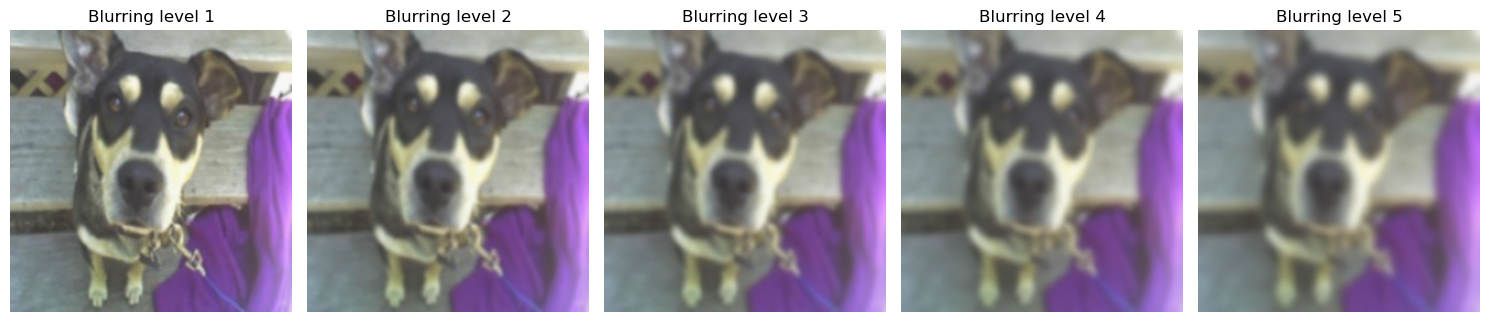

In [6]:
image_paths = ['data/training_blurred_1/training_image_blurred_100.jpg',
               'data/training_blurred_2/training_image_blurred_100.jpg',
               'data/training_blurred_3/training_image_blurred_100.jpg',
               'data/training_blurred_4/training_image_blurred_100.jpg',
               'data/training_blurred_5/training_image_blurred_100.jpg']

fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))

for ax, img_path in zip(axes, image_paths):

    image = imread_rgb(img_path)
    
    ax.imshow(image)
    ax.axis('off') 
    ax.set_title(f'Blurring level {img_path.split("_")[2][0]}')  

plt.tight_layout()
plt.show()

### Five Levels of Noise Example

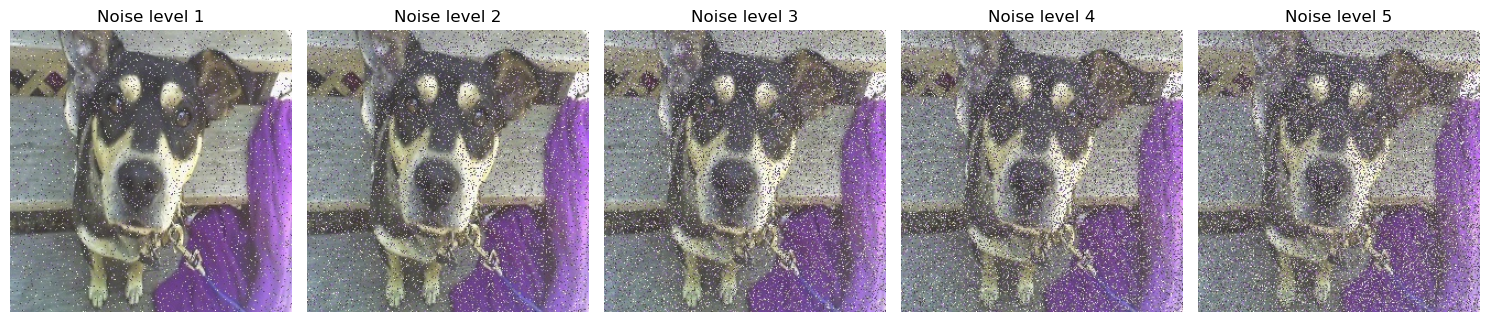

In [7]:
image_paths = ['data/training_noise_1/training_image_noise_100.jpg',
               'data/training_noise_2/training_image_noise_100.jpg',
               'data/training_noise_3/training_image_noise_100.jpg',
               'data/training_noise_4/training_image_noise_100.jpg',
               'data/training_noise_5/training_image_noise_100.jpg']

fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5)) 

for ax, img_path in zip(axes, image_paths):

    image = imread_rgb(img_path)
    
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f'Noise level {img_path.split("_")[2][0]}')

plt.tight_layout()
plt.show()

### Five Levels of Compression Example

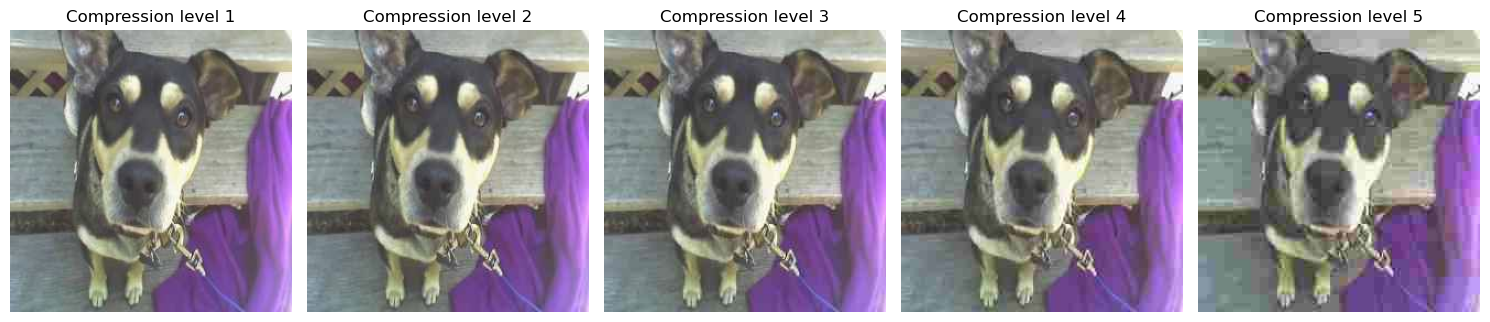

In [8]:
image_paths = ['data/training_compressed_1/training_image_compressed_100.jpg',
               'data/training_compressed_2/training_image_compressed_100.jpg',
               'data/training_compressed_3/training_image_compressed_100.jpg',
               'data/training_compressed_4/training_image_compressed_100.jpg',
               'data/training_compressed_5/training_image_compressed_100.jpg']

images = []

fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))

for ax, img_path in zip(axes, image_paths):
    image = imread_rgb(img_path)
    images.append(image)
    
    ax.imshow(image)
    ax.axis('off') 
    ax.set_title(f'Compression level {img_path.split("_")[2][0]}')

plt.tight_layout()
plt.show()